INFO:tensorflow:Enabled check-numerics callback in thread MainThread
Found 42749 images belonging to 14 classes.
Found 5337 images belonging to 14 classes.
Found 5356 images belonging to 14 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 14)                3598      
                                                     

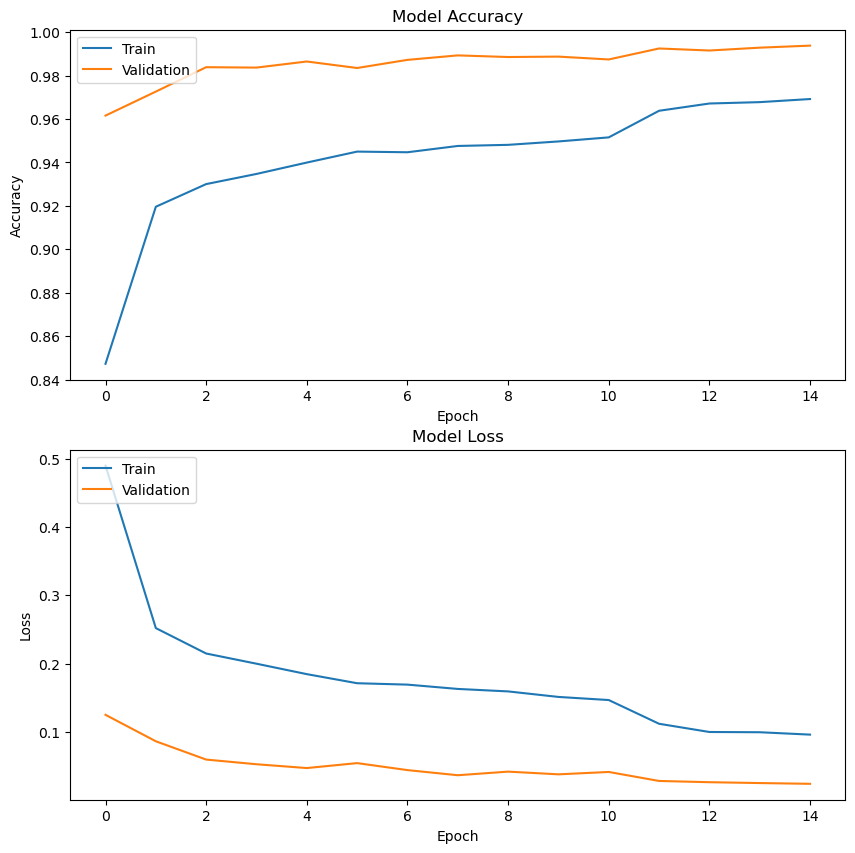

In [4]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import tensorflow as tf
tf.debugging.enable_check_numerics()
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

data_path = 'C:/Users/Jang Dong Min/Desktop/dataset'
imag_size = 64

# ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rescale=1./255,      # 픽셀값 범위를 0~1로 변환
    rotation_range=15,   # 이미지 회전 각도 범위
    zoom_range=0.3,      # 이미지 확대/축소 범위
    width_shift_range=0.1, # 이미지 가로 이동 범위
    height_shift_range=0.1, # 이미지 세로 이동 범위
    horizontal_flip=False,
    vertical_flip=False
)

# 데이터 경로 정의
train_data_path = os.path.join(data_path, 'train')
val_data_path = os.path.join(data_path, 'val')
test_data_path = os.path.join(data_path, 'test')

# 데이터 생성기 정의

# 훈련 데이터 불러오기
train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(imag_size, imag_size),
    batch_size=64,
    class_mode='categorical'
)

# 검증 데이터 생성
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_data_path,
    target_size=(imag_size, imag_size),
    batch_size=64,
    class_mode='categorical'
)


# 테스트 데이터 불러오기
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_path,
    target_size=(imag_size, imag_size),
    batch_size=64,
    class_mode='categorical'
)


# VGG16 모델 불러오기
vgg_model = VGG16(include_top=False, input_shape=(imag_size, imag_size, 3), weights='imagenet')

# VGG16 모델의 출력을 추가적인 레이어로 연결하기
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))

# VGG16 모델의 레이어는 훈련되지 않도록 고정
for layer in vgg_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ModelCheckpoint Callback 함수
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# 학습 데이터에서도 모델의 성능을 모니터링하도록 추가
checkpoint_train = ModelCheckpoint('best_model_train.h5', monitor='accuracy', save_best_only=True, mode='max')

# EarlyStopping Callback 함수
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,  # 최소한의 개선을 감지할 수 있도록 함
    patience=5,  # 5 epoch 이상 개선이 없으면 학습 중단
    mode='max',  # 최대값을 갖는 성능 지표를 사용
    baseline=None,  # 최초의 성능 지표를 기준으로 함
    restore_best_weights=True,  # 최적의 가중치를 복원함
    verbose=1  # 상세한 정보 출력
)

# ReduceLROnPlateau Callback 함수
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3,
    min_lr=1e-6,  # 학습률이 1e-6보다 작아지지 않도록 함
    cooldown=2,   # 학습률 감소 이벤트 후 2 epoch 동안 다른 콜백 함수가 실행되지 않도록 함
    verbose=1
)

# 정확도와 손실 그래프 출력 함수
def plot_history(history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
model.summary()
    
# 모델 학습
history = model.fit(train_generator, epochs=15, batch_size=64, 
                    validation_data=val_generator, validation_steps=len(val_generator), 
                    callbacks=[checkpoint, checkpoint_train, early_stop, reduce_lr])

# 모델 평가
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 학습 과정 그래프 출력
plot_history(history)